The config will be saved as ./room_env/data/room-config-xxl-v2.json

# of rooms: 32
# of static objects: 64 
# of independent objects: 64 
# of dependent objects: 64 

{'dependent_objects': ['dep_000',
                       'dep_001',
                       'dep_002',
                       'dep_003',
                       'dep_004',
                       'dep_005',
                       'dep_006',
                       'dep_007',
                       'dep_008',
                       'dep_009',
                       'dep_010',
                       'dep_011',
                       'dep_012',
                       'dep_013',
                       'dep_014',
                       'dep_015',
                       'dep_016',
                       'dep_017',
                       'dep_018',
                       'dep_019',
                       'dep_020',
                       'dep_021',
                       'dep_022',
                       'dep_023',
                

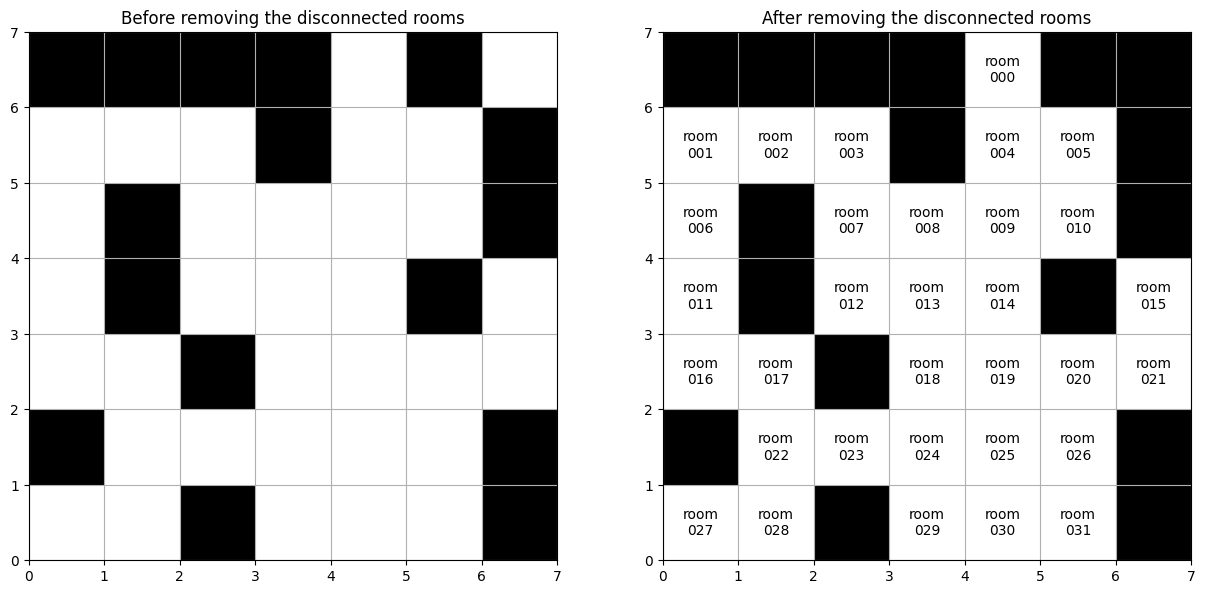

In [113]:
import random
from room_env.create_room2 import RoomCreator

room_creator = RoomCreator(
    filename="xxl",
    grid_length=7,
    num_rooms=32,
    num_static_objects=64,
    num_independent_objects=64,
    num_dependent_objects=64,
    room_prob=0.7,
    minimum_transition_stay_prob=0.6,
    give_fake_names=False,
)
room_creator.run()

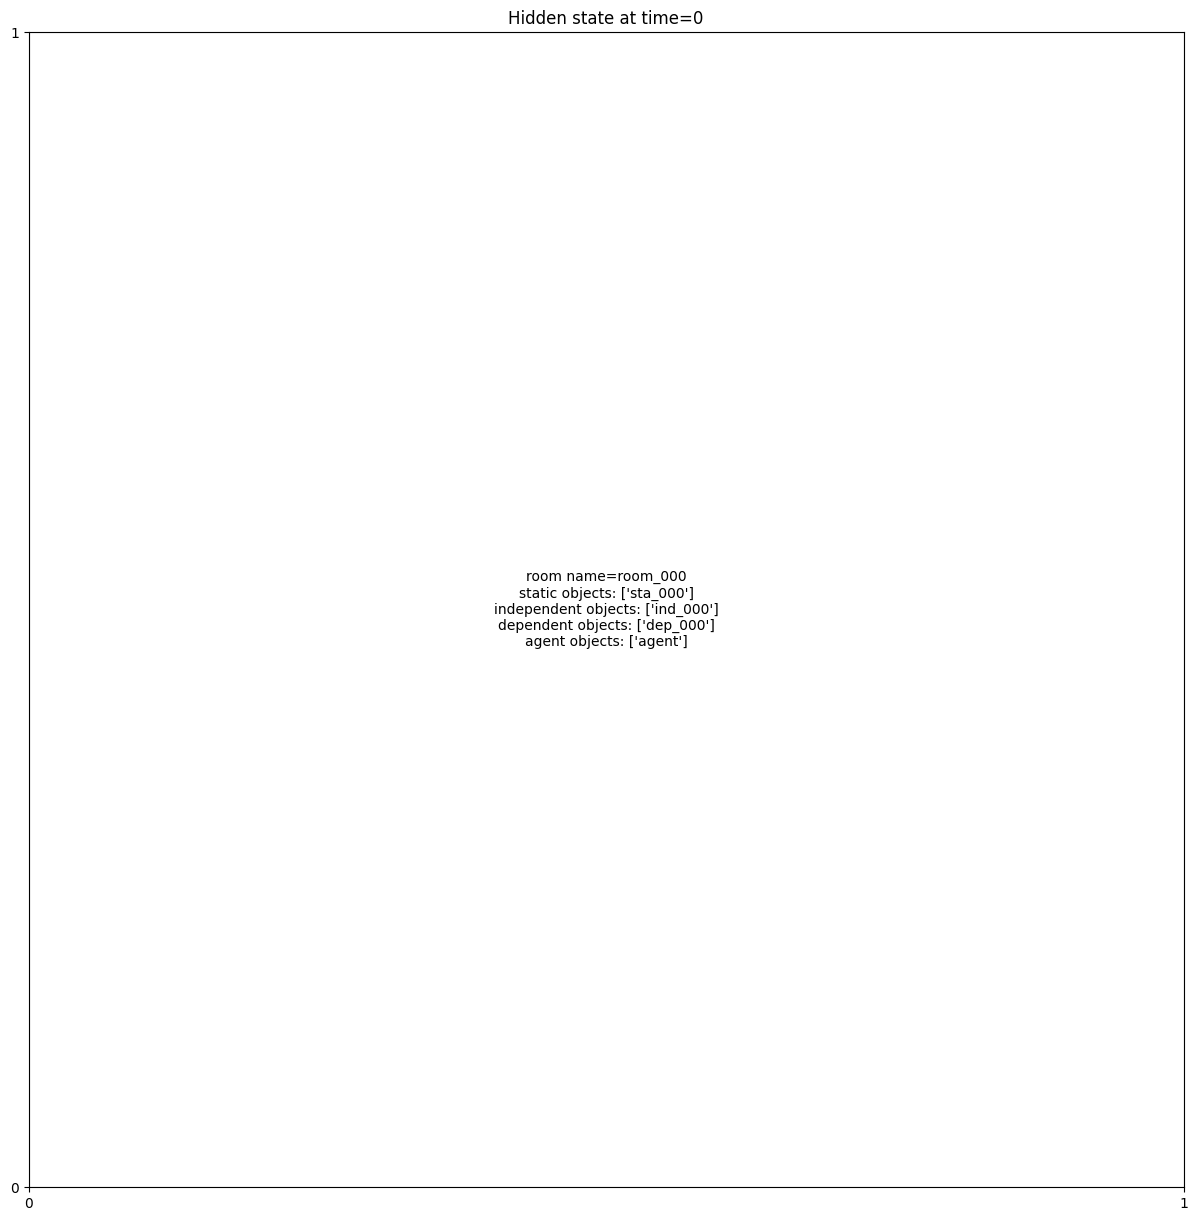

The number of room: 1
The number of static_objects: 1
The number of independent_objects: 1
The number of dependent_objects: 1


In [19]:
from room_env.envs.room2 import RoomEnv2

env_config = {
    "question_prob": 1.0,
    "seed": 0,
    "terminates_at": 99,
    "randomize_observations": True,
    "room_size": "xxs",
}

env = RoomEnv2(**env_config)
observations, info = env.reset()
env.render("image", save_fig_dir="./DEBUG/")
for key, val in env.names.items():
    print(f"The number of {key}: {len(val)}")

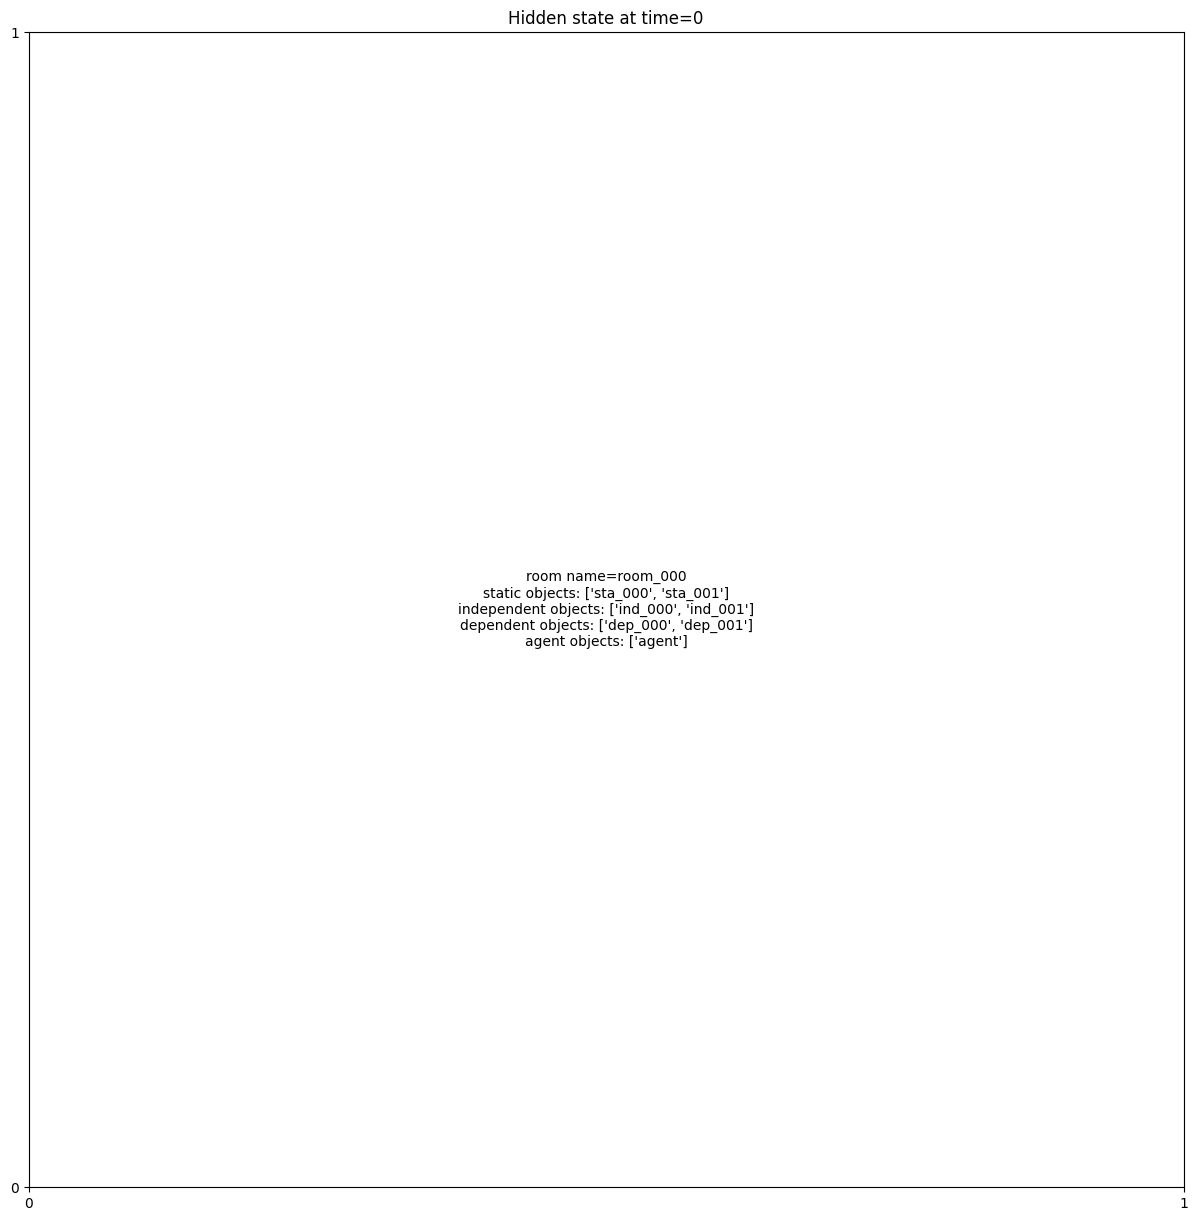

The number of room: 1
The number of static_objects: 2
The number of independent_objects: 2
The number of dependent_objects: 2


In [21]:
from room_env.envs.room2 import RoomEnv2

env_config = {
    "question_prob": 1.0,
    "seed": 0,
    "terminates_at": 99,
    "randomize_observations": True,
    "room_size": "xs",
}

env = RoomEnv2(**env_config)
observations, info = env.reset()
env.render("image", save_fig_dir="./DEBUG/")
for key, val in env.names.items():
    print(f"The number of {key}: {len(val)}")

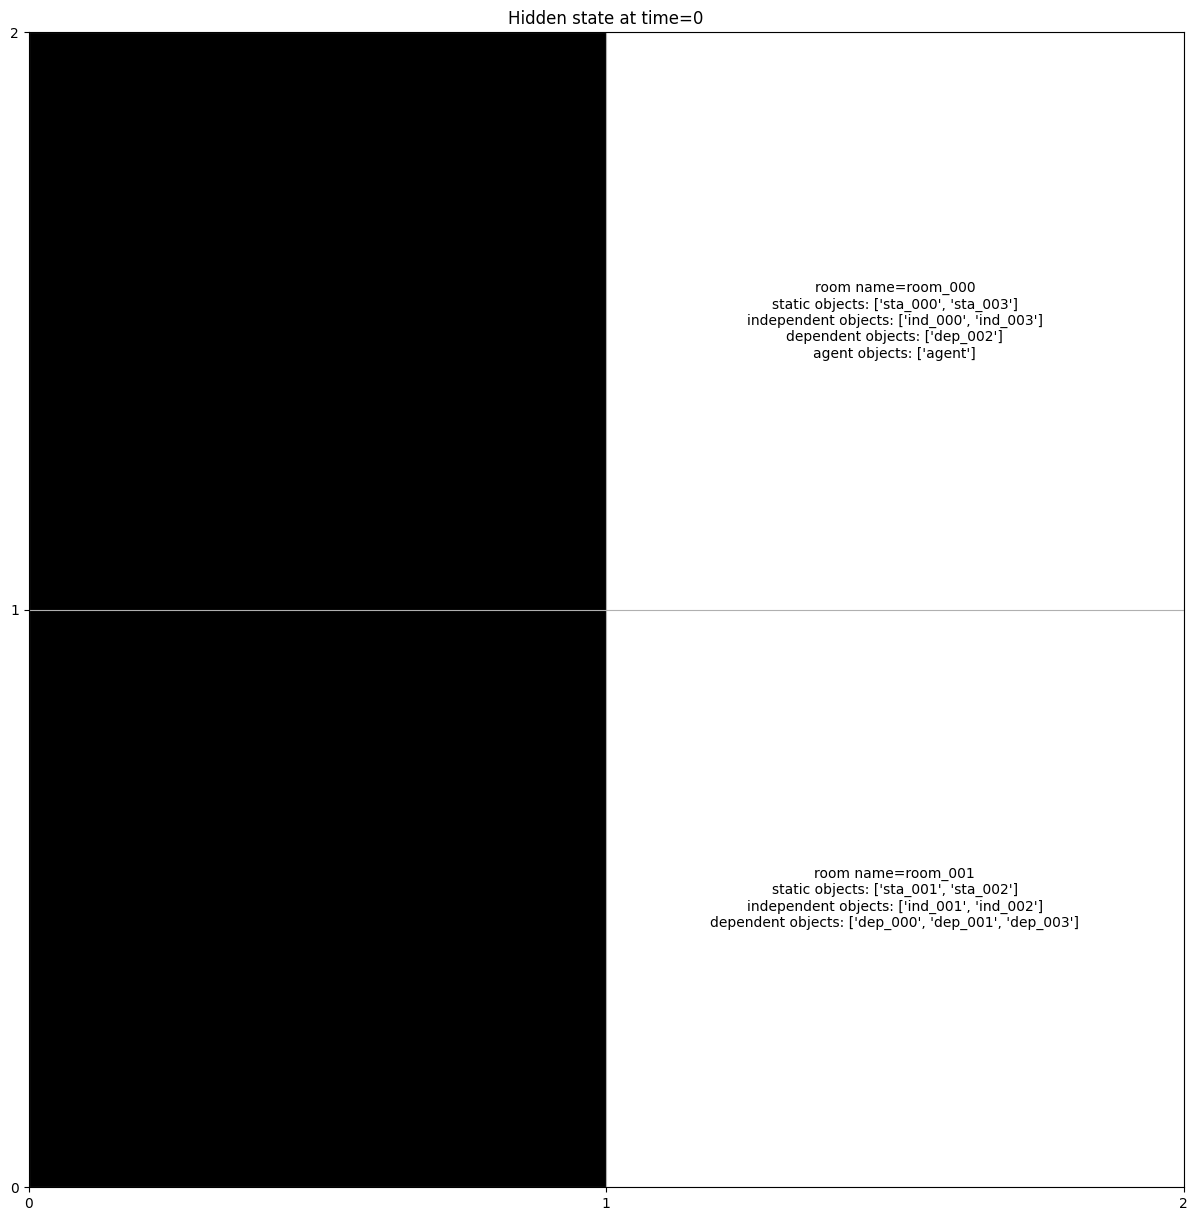

The number of room: 2
The number of static_objects: 4
The number of independent_objects: 4
The number of dependent_objects: 4


In [23]:
from room_env.envs.room2 import RoomEnv2

env_config = {
    "question_prob": 1.0,
    "seed": 2,
    "terminates_at": 99,
    "randomize_observations": True,
    "room_size": "s",
}

env = RoomEnv2(**env_config)
observations, info = env.reset()
env.render("image", save_fig_dir="./DEBUG/")
for key, val in env.names.items():
    print(f"The number of {key}: {len(val)}")

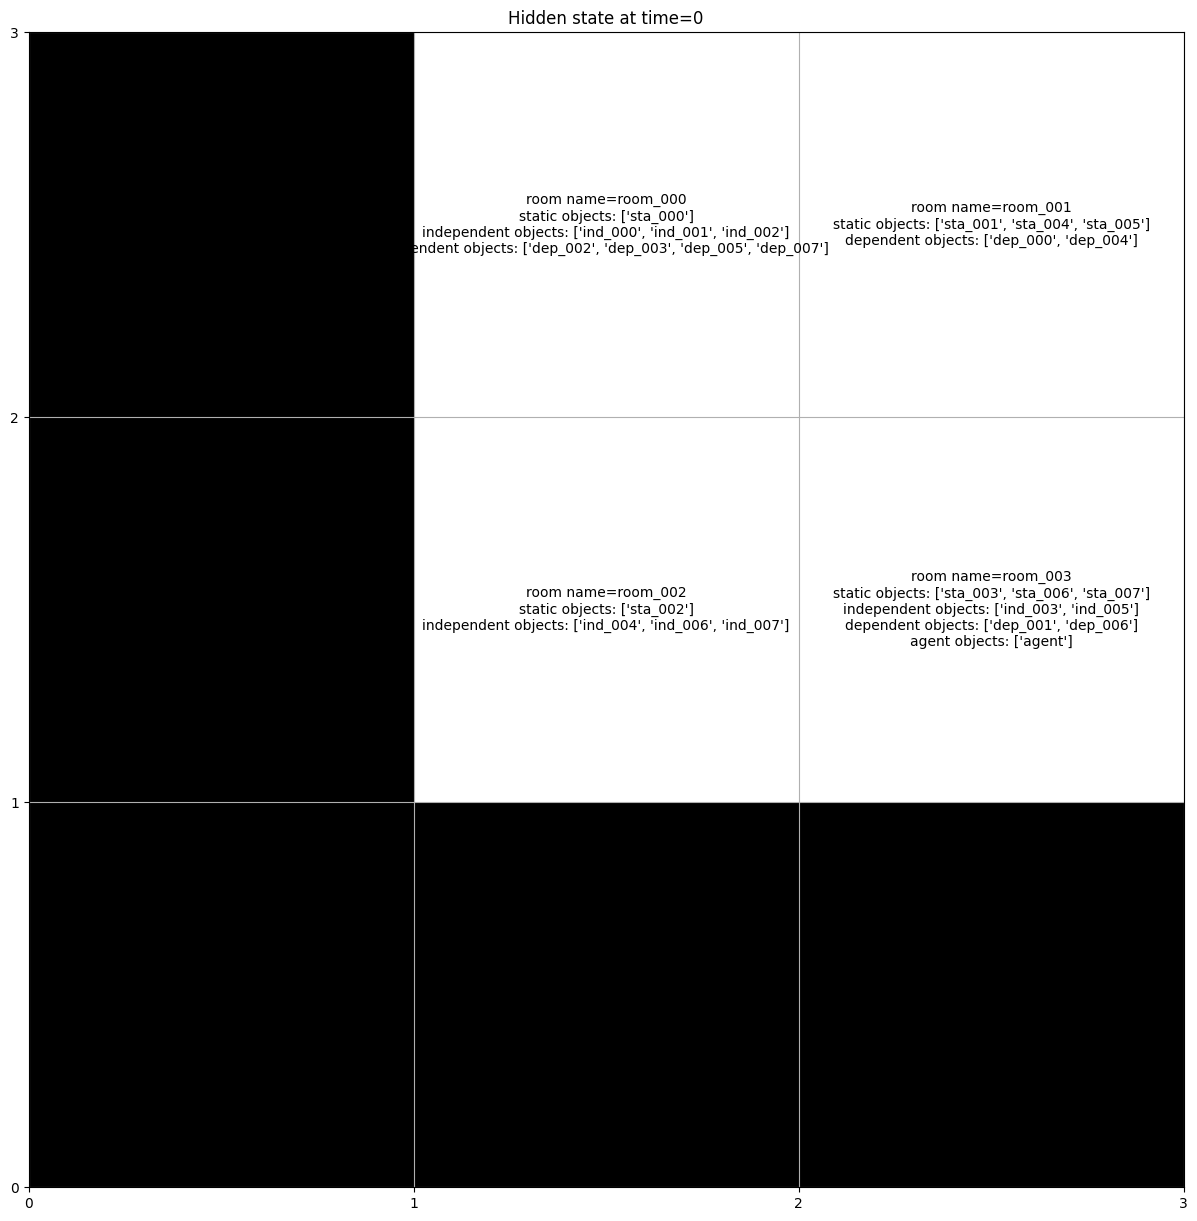

The number of room: 4
The number of static_objects: 8
The number of independent_objects: 8
The number of dependent_objects: 8


In [40]:
from room_env.envs.room2 import RoomEnv2

env_config = {
    "question_prob": 1.0,
    "seed": 3,
    "terminates_at": 99,
    "randomize_observations": True,
    "room_size": "m",
}

env = RoomEnv2(**env_config)
observations, info = env.reset()
env.render("image", save_fig_dir="./DEBUG/")
for key, val in env.names.items():
    print(f"The number of {key}: {len(val)}")

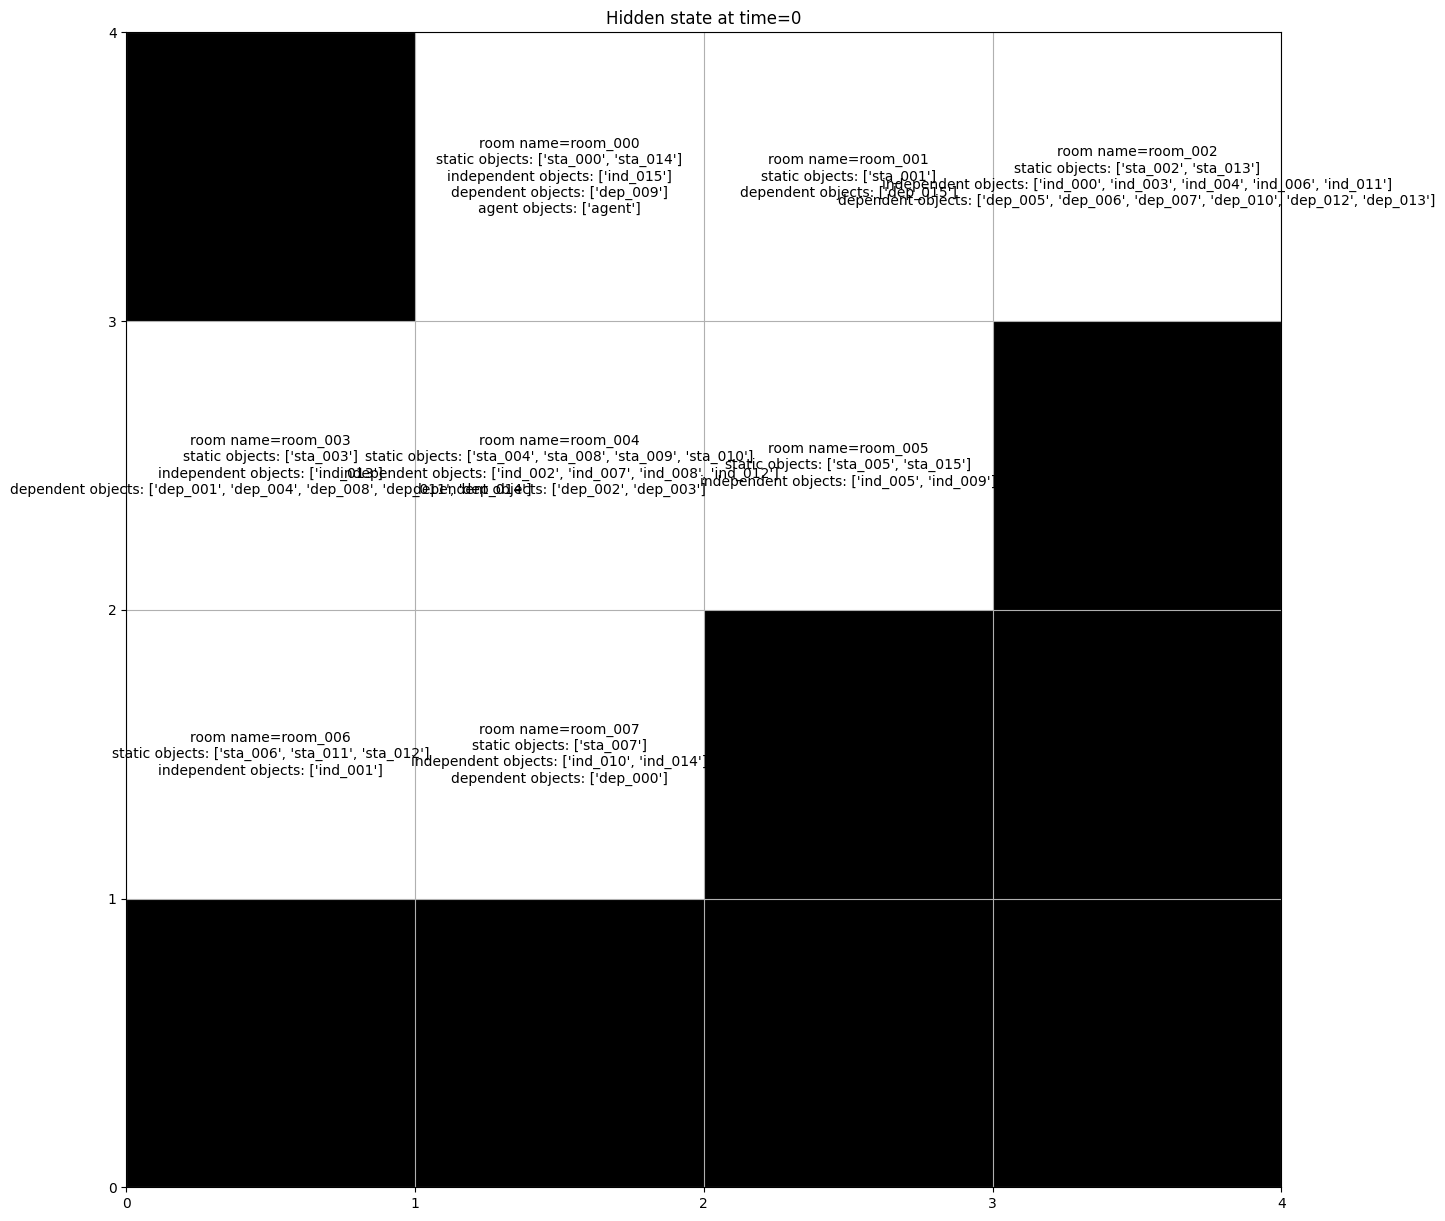

The number of room: 8
The number of static_objects: 16
The number of independent_objects: 16
The number of dependent_objects: 16


In [66]:
from room_env.envs.room2 import RoomEnv2

env_config = {
    "question_prob": 1.0,
    "seed": 2,
    "terminates_at": 99,
    "randomize_observations": True,
    "room_size": "l",
}

env = RoomEnv2(**env_config)
observations, info = env.reset()
env.render("image", save_fig_dir="./DEBUG/")
for key, val in env.names.items():
    print(f"The number of {key}: {len(val)}")

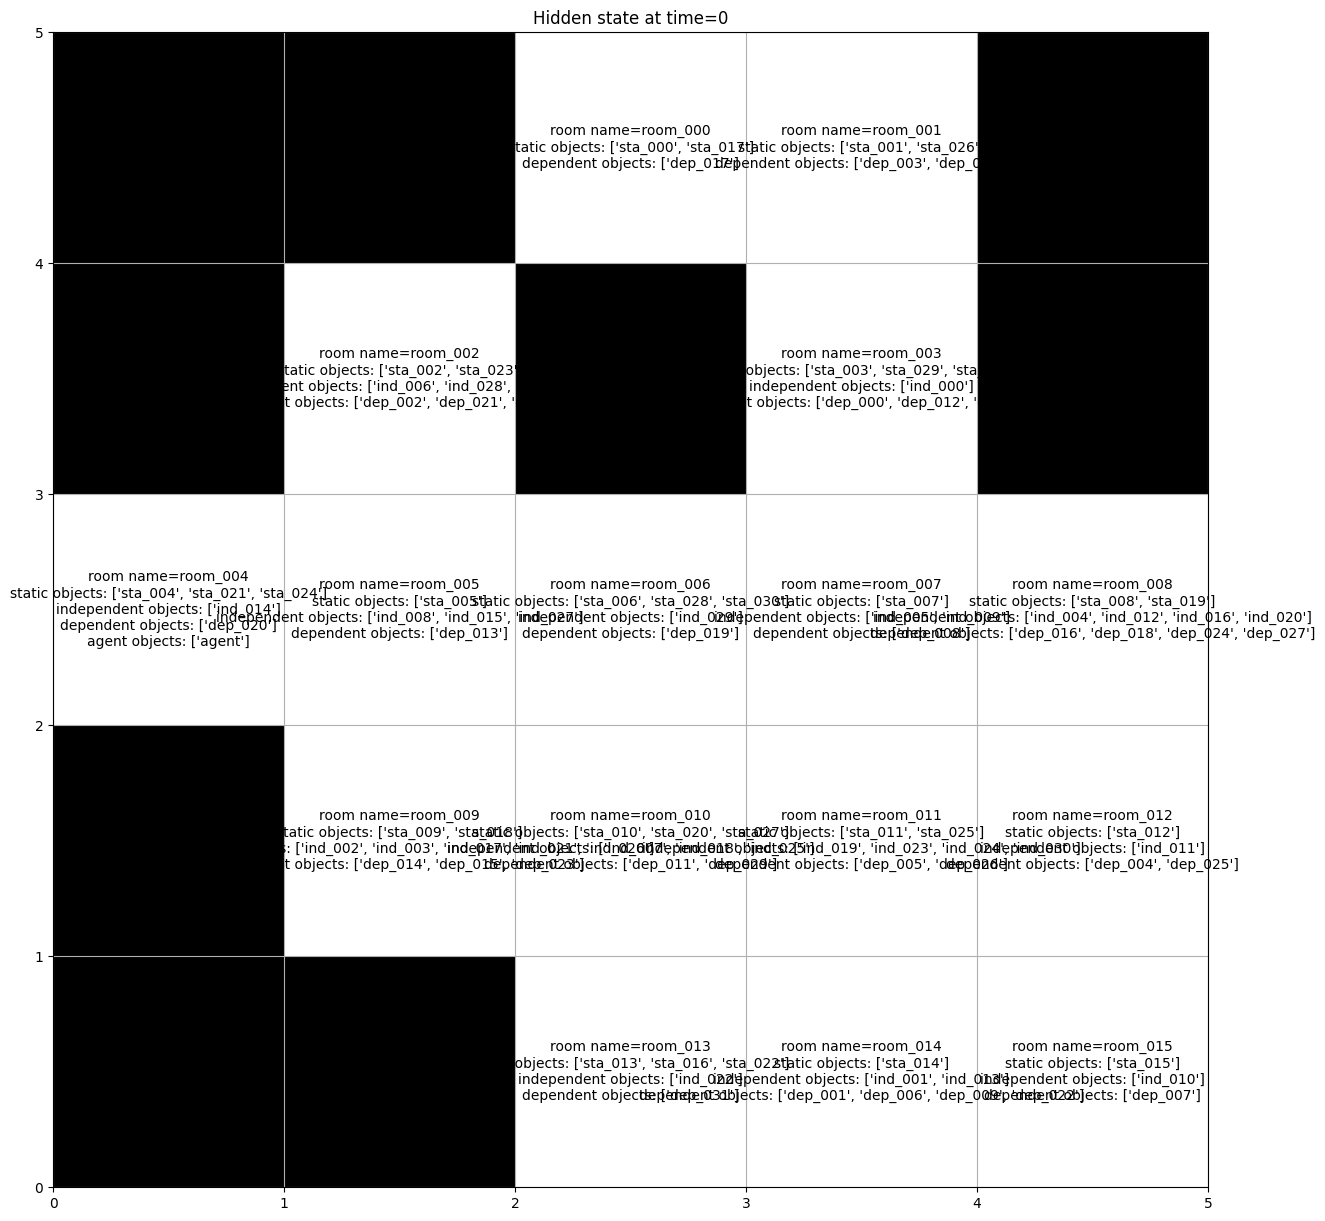

The number of room: 16
The number of static_objects: 32
The number of independent_objects: 32
The number of dependent_objects: 32


In [72]:
from room_env.envs.room2 import RoomEnv2

env_config = {
    "question_prob": 1.0,
    "seed": 0,
    "terminates_at": 99,
    "randomize_observations": True,
    "room_size": "xl",
}

env = RoomEnv2(**env_config)
observations, info = env.reset()
env.render("image", save_fig_dir="./DEBUG/")
for key, val in env.names.items():
    print(f"The number of {key}: {len(val)}")

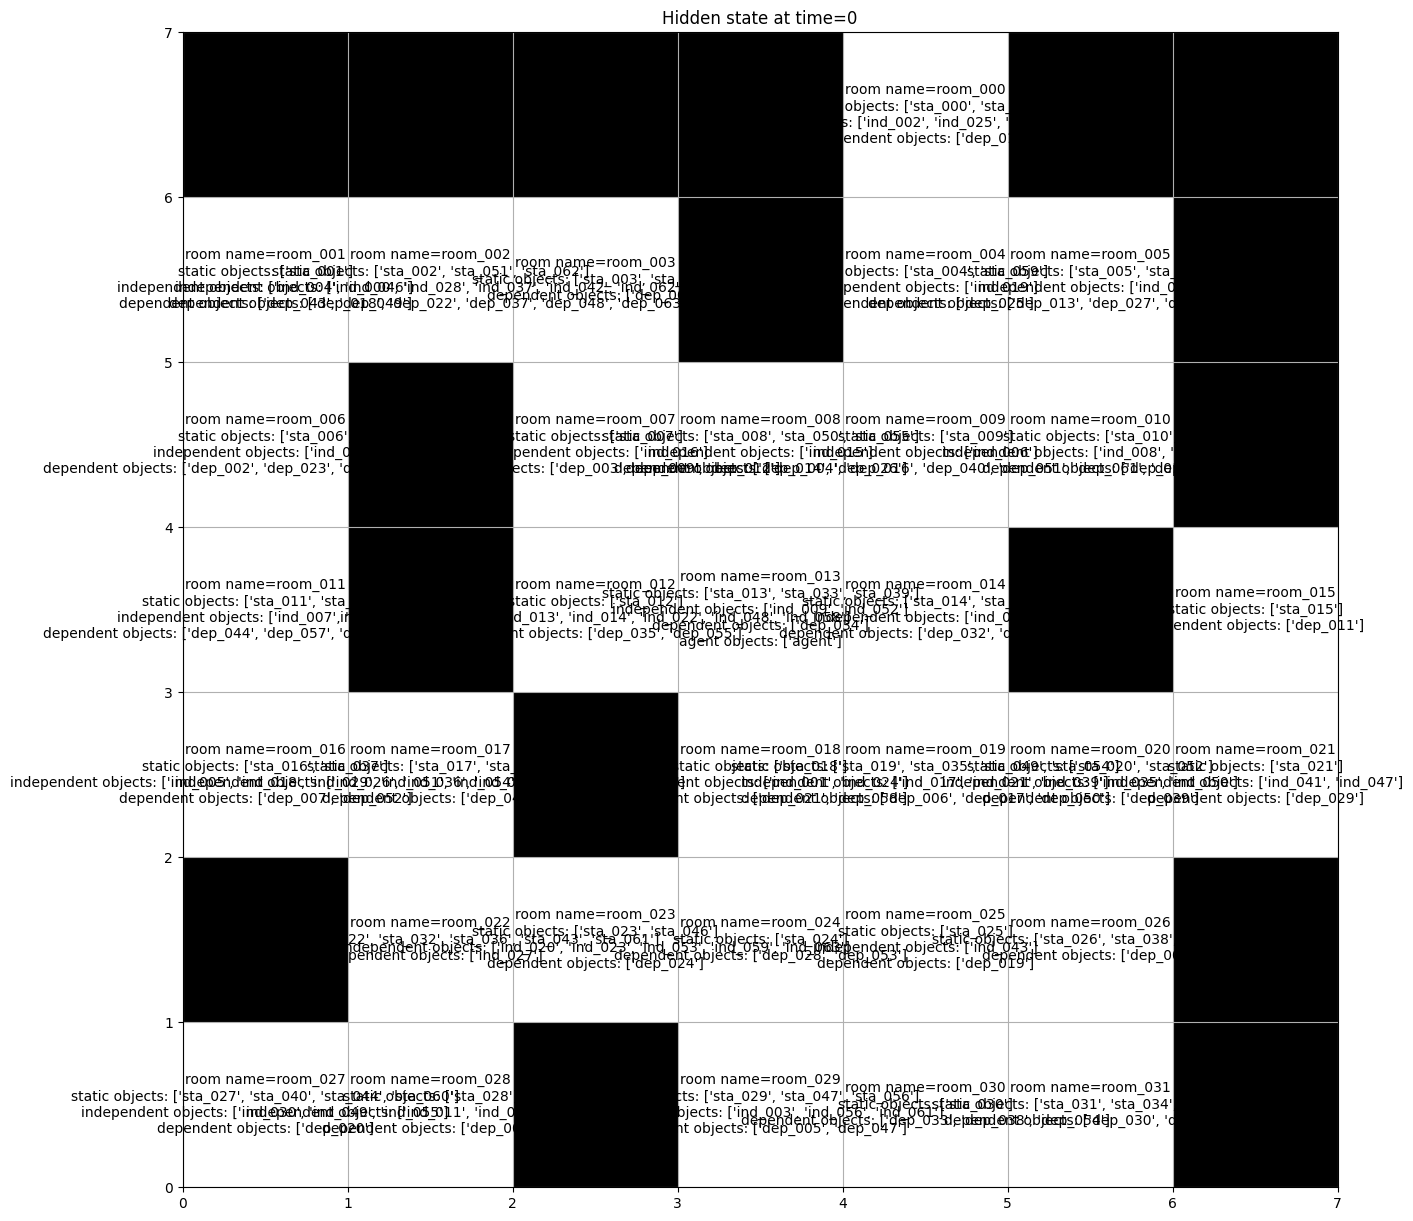

The number of room: 32
The number of static_objects: 64
The number of independent_objects: 64
The number of dependent_objects: 64


In [114]:
from room_env.envs.room2 import RoomEnv2

env_config = {
    "question_prob": 1.0,
    "seed": 0,
    "terminates_at": 99,
    "randomize_observations": True,
    "room_size": "xxl",
}

env = RoomEnv2(**env_config)
observations, info = env.reset()
env.render("image", save_fig_dir="./DEBUG/")
for key, val in env.names.items():
    print(f"The number of {key}: {len(val)}")